In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

<h2>SVM Analysis</h2>
This classifier separates data points using a hyperplane with the largest amount of margin. This model finds an optimal hyperplane which can help in classifying new data points. It is often used for classification problems which satisfies our binary classification use case. 

The goal of SVM is to find a maximum marginal hyperplane that best divides the dataset into classes. Support vectors are the data points closest to the hyperplane. 

<strong>How does SVM work?</strong>

[1] Generate hyperplanes which separates the classes in the best way. 
[2] Select the right hyperplane with maximum separation from the nearest points that define the boundary. Given non-linear and inseparable planes, kernal tricks can be used to transform the input space to a higher dimensional space.

<strong>Scikit Learn Tuning Parameters</strong>

[1] From the EDA, it was difficult to see any prominent relationships between the outputs and inputs. For that reason, we test SVC and NuSVC SVM's disregarding LinearSVC. SVC and NuSVC simply vary in their mathematical formulations.

[2] Kernel: Specifies the kernel type to be used in the algorithm. Some possible values are linear, poly, rbf, sigmoid, or precomputed.

[3] C: The strength of regularization => for SVC 

[4] Degree of the polynomial

[5] class_weight: Given that we have many positive and few negative, balancing the class weight might be something of interest.

[6] gamma (scale or auto): Useful for non-linear kernal like RBF. This defines the behavior of the decision boundary.

Sources:
https://scikit-learn.org/stable/modules/svm.html

https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

<strong>Defining ROC and AUC Score Function</strong>

In [17]:
from sklearn.metrics import roc_curve, auc

def predictive_probability_results(y_true, y_prob, label="Model", title="ROC Curve"):
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
filename = '/kickstarter_one_hot_cleaned.csv'
filepath = '/Users/zarahtaufique/Desktop/SJSU/Year4Semester2/CMPE188/kickstarter-project-success-predictions/data'
pd.set_option('display.max_columns', None)

full_kickstarter_df = pd.read_csv(filepath+filename, low_memory=False)
print(full_kickstarter_df.columns)

Index(['name', 'blurb', 'goal', 'disable_communication', 'country', 'currency',
       'deadline', 'state_changed_at', 'created_at', 'launched_at',
       'staff_pick', 'backers_count', 'static_usd_rate', 'usd_pledged',
       'category', 'spotlight', 'name_len_clean', 'blurb_len_clean',
       'deadline_month', 'deadline_day', 'deadline_hr', 'created_at_month',
       'created_at_day', 'created_at_hr', 'launched_at_month',
       'launched_at_day', 'launched_at_yr', 'launched_at_hr',
       'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days', 'SuccessfulBool', 'TOPCOUNTRY',
       'LaunchedTuesday', 'DeadlineWeekend', 'app', 'help', 'new', 'world',
       'canceled', 'country_grouped_CA', 'country_grouped_GB',
       'country_grouped_Other', 'country_grouped_US', 'currency_grouped_CAD',
       'currency_grouped_EUR', 'currency_grouped_GBP',
       'currency_grouped_Other', 'currency_grouped_USD',
       'deadline_weekday_Friday', 'deadline_weekday_

In [19]:
# Dropping columns before training
cols_to_drop = [
    'name',
    'blurb',
    'category',
    'country',
    'currency',
    'deadline',
    'state_changed_at',
    'created_at',
    'launched_at',
    'spotlight' # Manually dropping the spotlight column as this is a source for data leakage
]

starter_df = full_kickstarter_df.drop(cols_to_drop, axis=1)
print(starter_df.head())

       goal  disable_communication  staff_pick  backers_count  \
0    1500.0                      0           0              0   
1     500.0                      0           0              0   
2  100000.0                      0           0              5   
3    5000.0                      0           0              0   
4    3222.0                      0           0             17   

   static_usd_rate  usd_pledged  name_len_clean  blurb_len_clean  \
0         1.000000     0.000000               9               16   
1         1.000000     0.000000               4               15   
2         1.000000   120.000000               8               10   
3         1.000000     0.000000               6               13   
4         1.114613   396.802395               7               18   

   deadline_month  deadline_day  deadline_hr  created_at_month  \
0               1            23           10                11   
1               5             1           16                 2   
2 

Many columns are labeled with true/false variables. SVMs are mathematical models requiring numerical inputs. 

In [20]:
for col in starter_df.columns:
    if starter_df[col].dtype == bool:
        starter_df[col] = starter_df[col].astype(int)

print(starter_df.dtypes)

goal                          float64
disable_communication           int64
staff_pick                      int64
backers_count                   int64
static_usd_rate               float64
                               ...   
category_grouped_Plays          int64
category_grouped_Software       int64
category_grouped_Sound          int64
category_grouped_Wearables      int64
category_grouped_Web            int64
Length: 77, dtype: object


<h3>Preliminary Analysis with Minimal Model Tuning</h3>

In [21]:
# All input features
X = starter_df.drop('SuccessfulBool', axis=1)

# Get the output
Y = starter_df['SuccessfulBool']

models = [
    ('RBF SVC SVM', SVC(kernel='rbf', C=1, random_state=42)), # RBF is the default for SVM
    ('RBF NuSVC SVM', NuSVC(kernel='rbf', random_state=42)),
]

In [22]:
results = []
preliminary_results = []
names = []
scoring = 'accuracy'
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} accuracy (±{cv_results.std():.4f})")

RBF SVC SVM: 0.7818 accuracy (±0.0084)
RBF NuSVC SVM: 0.7706 accuracy (±0.0108)


<h3>Analysis of Different Kernel Functions</h3>

<strong>Kernal Function Notes</strong>
The kernel function is used to take data as input and transform it into the required form of processing data.

[1] Linear Kernel: This is best suited for data that is linearly separable. From EDA, we did not see much linear correlation between the input and output data. As a result, we skip this kernel.

[2] Polynomial Kernel: This allows for mapping of more complex relationships by introducing polynomial terms. This is useful for data that is not linearly separable but still follows a pattern.

[3] RBF Kernel: This is the most widely used kerne;. It maps the data into an infinite-dimensional space marking it highly effective for complex classification problems. We use this when the decision boundary is highly non-linear.

[4] Sigmoid: This is inspired by neural networks. It is suitable for neural networks and non-linear classifiers.

Source: https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/
A cool video for kernal visualization: https://www.youtube.com/watch?v=3liCbRZPrZA

In [23]:
kernel_models = [
    ('Poly SVC SVM', SVC(kernel='poly', C=1, random_state=42)),
    ('Sigmoid SVC SVM', SVC(kernel='sigmoid', C=1, random_state=42)),

    ('Poly NuSVC SVM', NuSVC(kernel='poly', random_state=42)),
    ('Sigmoid NuSVC SVM', NuSVC(kernel='sigmoid', random_state=42))
]

kernel_results = []
kernel_preliminary_results = []
kernel_names = []
scoring = 'accuracy'
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for name, model in kernel_models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=1)
    kernel_results.append(cv_results)
    kernel_names.append(name)
    print(f"{name}: {cv_results.mean():.4f} accuracy (±{cv_results.std():.4f})")

Poly SVC SVM: 0.7135 accuracy (±0.0083)
Sigmoid SVC SVM: 0.7289 accuracy (±0.0070)
Poly NuSVC SVM: 0.5321 accuracy (±0.2422)
Sigmoid NuSVC SVM: 0.7299 accuracy (±0.0068)


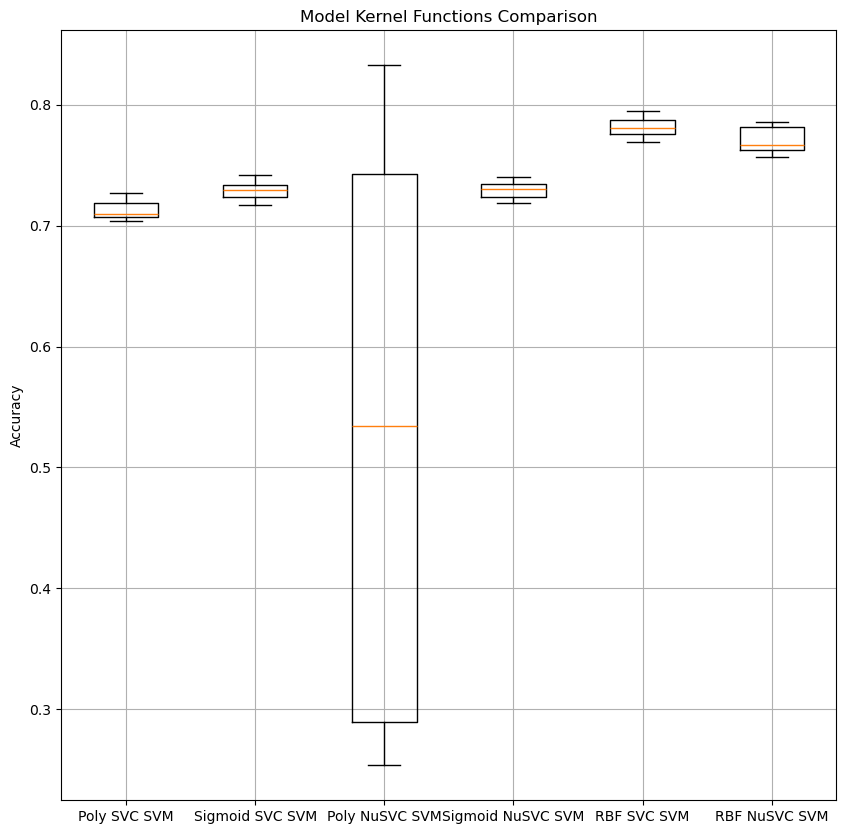

In [24]:
plt.figure(figsize=(10, 10))
plt.boxplot(kernel_results + results)
plt.title('Model Kernel Functions Comparison')
plt.ylabel('Accuracy')
all_names = kernel_names + names
plt.xticks(range(1, len(all_names) + 1), all_names)
plt.grid(True)
plt.show()

From the analysis of the kernel functions, so far it seems that RBF might be the best choice. However, given that the input paramters are default, tuning the paramters further can help with model accuracy.

<strong>A summary of the results:</strong>

[1] RBF SVC: Best overall given our nonlinear data. Relatively low standard deviation

[2] RBG NuSVC: Still strong, slightly worse that the previous

[3] Sigmoid SVC and NuSVM: These perform similarily to each other

[4] Poly SVC: Weaker than other models. Poly SVC in general is sensitive to regularization value C, so tuning this is of interest.

[5] Poly NuSVC: Weaker which might indicate this model is overfitting. The accuracy of the models vary widely from 0.3 and ~0.75. These tells us the models are not doing well across different folds indicating the model might be potentially overfitted.

These models have a fairly low standard devilation indicating that the model is consistent and stable across different folds. 
Further analysis such as looking at the ROC and AUC scores of these classification models is required.

<h3>Analysis of Regularization Parameter for SVCs</h3>

<strong>Background</strong>

The parameter C is used to set the amount of regularization, or a technqiue to reduce overfitting. C controls the trade-off between margin width and classification error.
Given that the Poly SVC model seems to be overfitted, we will test different regularization amounts for Poly SVC and RBF SVC (previously model accurate model). 

A low C indicates a larger margin and a model that is more tolerant for misclassification. A high C has more narrow margin making it less tolerant for error.

Source: 
https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html#sphx-glr-auto-examples-svm-plot-svm-scale-c-py

<strong>Regularization Tuning for RBF SVC Functions</strong>

In [25]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
rbf_regularization_results = []

for C in C_values:
    model = SVC(kernel='rbf', C=C, random_state=42)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy', n_jobs=-1)
    rbf_regularization_results.append(cv_results)
    print(f"C={C}: Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

C=0.001: Mean accuracy = 0.7083, Std = 0.0090
C=0.01: Mean accuracy = 0.7162, Std = 0.0077
C=0.1: Mean accuracy = 0.7455, Std = 0.0082
C=1: Mean accuracy = 0.7818, Std = 0.0084
C=10: Mean accuracy = 0.8212, Std = 0.0086
C=100: Mean accuracy = 0.8613, Std = 0.0079
C=1000: Mean accuracy = 0.8965, Std = 0.0109


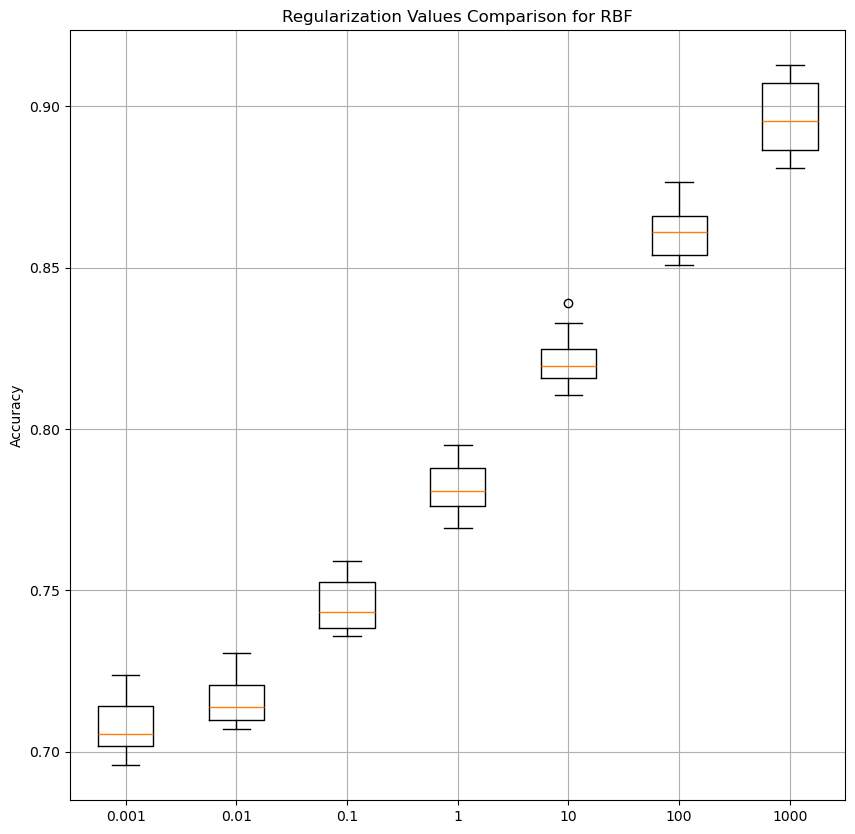

In [32]:
plt.figure(figsize=(10, 10))
plt.boxplot(rbf_regularization_results)
plt.title('Regularization Values Comparison for RBF')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(C_values) + 1), C_values)
plt.grid(True)
plt.show()

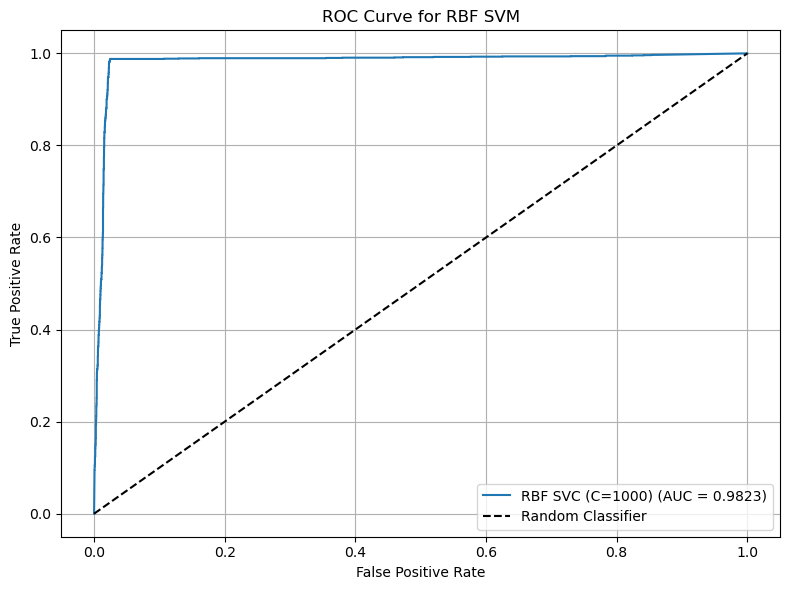

In [28]:
from sklearn.model_selection import train_test_split

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Fit model
model = SVC(kernel='rbf', C=1000, probability=True, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC
predictive_probability_results(y_test, y_proba, label="RBF SVC (C=1000)", title="ROC Curve for RBF SVM")

For RBF SWM, we see that as C increases, the accuracy steadily improves. C = 1000 gives the higest median accuracy and a quite low standard deviation, meaning stable and high performance (around 89%). A higher C value indivcates that it is better to penalize misclassifications more heavily on the dataset.

We also observe the ROC/AUC score for the highest performing model. The ROC graph is very close to the top-left corner indicating that there is a low false positive rate and high true positive rate. This indicates that the model is not only accurate but a reliable classifier. 

<strong>Regularization Tuning for Poly SVC Functions</strong>

In [33]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
poly_regularization_results = []

for C in C_values:
    model = SVC(kernel='poly', C=C, random_state=42)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy', n_jobs=-1)
    poly_regularization_results.append(cv_results)
    print(f"C={C}: Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

C=0.001: Mean accuracy = 0.7085, Std = 0.0090
C=0.01: Mean accuracy = 0.7091, Std = 0.0089
C=0.1: Mean accuracy = 0.7110, Std = 0.0088
C=1: Mean accuracy = 0.7135, Std = 0.0083
C=10: Mean accuracy = 0.7170, Std = 0.0078
C=100: Mean accuracy = 0.7215, Std = 0.0077
C=1000: Mean accuracy = 0.7260, Std = 0.0078


The data does not seem to be overfitted as with varying values of regularization, the model performs consistently around 71% accuracy with relatively low standard deviation. It might be worth adjusting the gamma coefficient before ruling out this kernel completely.

In NuSVC, the nu parameter defines an upper bound on the fraction of margin errors and a lower bound on the fraction of support vectors.
For example, setting nu = 0.4 guarantees that no more than 40% of the training data will be margin violators, and at least 40% will be support vectors

Source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html

In [45]:
nu_value = [0.5, 0.4, 0.3]
poly_nu_regularization_results = []

for nu in nu_value:
    model = NuSVC(kernel='poly', nu=nu, random_state=42)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy', n_jobs=-1)
    poly_nu_regularization_results.append(cv_results)
    print(f"Nu={nu}: Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

Nu=0.5: Mean accuracy = 0.5321, Std = 0.2422
Nu=0.4: Mean accuracy = 0.7996, Std = 0.0556
Nu=0.3: Mean accuracy = 0.6168, Std = 0.2522


We see that a Nu value of 0.4 provides the highest mean accuracy, but the standard deviation gives indication that not all folds are consistent. The other two Nu values result in a model accuracy that is similar to essentially guessing the data.

<h3>Analysis of Gamma Parameter for SVCs</h3>